## Given code

In [25]:
import numpy as np
import scipy as scipy
from scipy.linalg import toeplitz
from scipy.sparse import csr_matrix, kron

def blur(N, band=3, sigma=0.7):
    z = np.block([np.exp(-(np.array([range(band)])**2)/(2*sigma**2)), np.zeros((1, N-band))])
    A = toeplitz(z)
    A = csr_matrix(A)
    A = (1/(2*np.pi*sigma**2))*kron(A,A)
    
    x = np.zeros((N, N))
    N2 = round(N/2)
    N3 = round(N/3)
    N6 = round(N/6)
    N12 = round(N/12)
    
    # Large elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 1:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[2:2+2*N6, N3-1:3*N3-1] =  T
    
    # Small elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 0.6:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[N6:3*N6, N3-1:3*N3-1] =  x[N6:3*N6, N3-1:3*N3-1] + 2*T
    x[x==3] = 2*np.ones((x[x==3]).shape)
    
    T = np.triu(np.ones((N3,N3)))
    mT, nT = T.shape
    x[N3+N12:N3+N12+nT,1:mT+1] = 3*T
    
    T = np.zeros((2*N6+1,2*N6+1))
    mT, nT = T.shape
    T[N6,:] = np.ones((1,nT))
    T[:,N6] = np.ones((mT))
    x[N2+N12:N2+N12+mT,N2:N2+nT] = 4*T
    
    x = x[:N,:N].reshape(N**2,1)
    b = A @ x
    
    return A, b, x

## Section A

In [26]:
import matplotlib.pyplot as plt

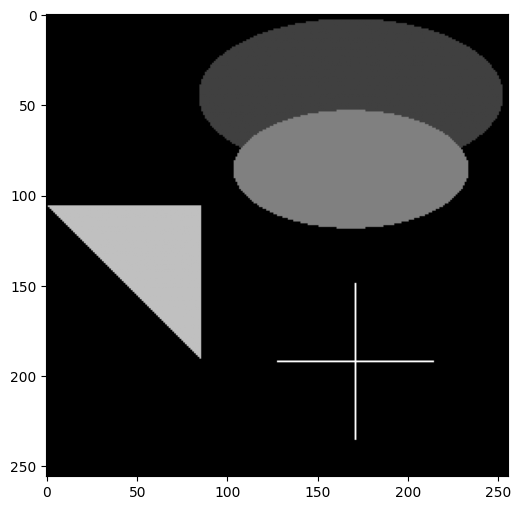

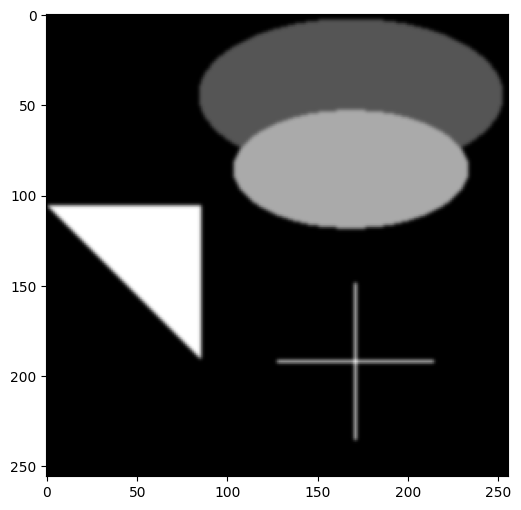

In [27]:
A,b,x = blur(256, 5, 1)
plt.figure(figsize=(6,6))
plt.imshow(x.reshape(256 ,256), cmap='gray')
plt.show()
plt.figure(figsize=(6,6))
plt.imshow(b.reshape(256 ,256), cmap='gray')
plt.show()

In [28]:
b.shape

(65536, 1)

In [29]:
def exact_quad(A):
    def lsearch(f ,xk ,gk):
        return (np.linalg.norm(gk) ** 2) / (2 * np.linalg.norm(A.dot(gk)) ** 2)
    return lsearch


def generic_grad(f, gf, lsearch, x0, num_iter=1000):
    x = x0
    i = 0
    while i < num_iter:
        g = gf(x)
        t = lsearch(f, x ,g)
        x = x - t * g
        i += 1
    return x

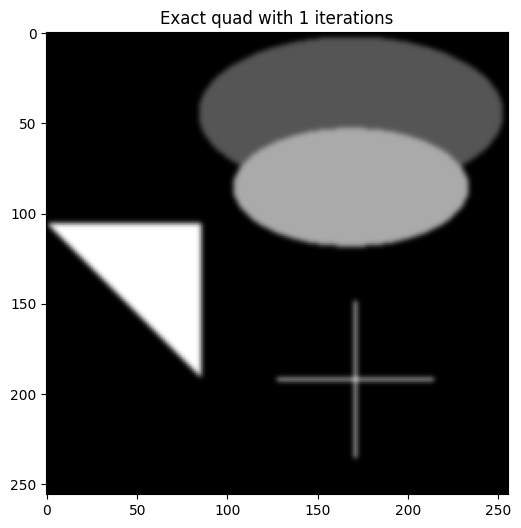

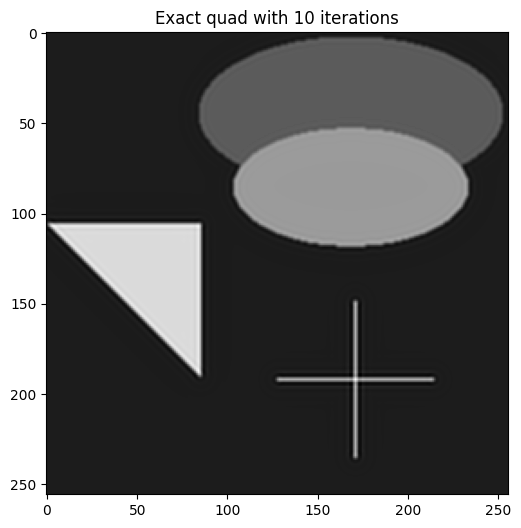

In [34]:
A_T = A.T
AT_A = A_T.dot(A)
f = lambda x: np.linalg.norm(A.dot(x)-b).pow(2)
gf = lambda x: 2 * (AT_A.dot(x) - A_T.dot(b))
lsearch = exact_quad(A)
x0 = np.zeros(b.shape)
for iter_num in [1, 10, 100, 1000]:
    x = generic_grad(f, gf, lsearch, x0, iter_num)
    plt.figure(figsize=(6,6))
    plt.title("Exact quad with " + str(iter_num) + " iterations")
    plt.imshow(x.reshape(256 ,256), cmap='gray')
    plt.show()